In [3]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
num_folds = 10
k = 2
color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 16

Dataset_Name = f"Lung.Colon.Cancer.Hist.{num_folds}k{str(k)}"
work_dir = "drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/"
base_dir = "drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all/"

print(f"Dataset_Name = {Dataset_Name}")

Dataset_Name = Lung.Colon.Cancer.Hist.10k2


In [5]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

In [6]:
csv_file = "drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all.csv"
df_original = pd.read_csv(csv_file) # , delimiter = " ", header=None
#train_df_original.columns = ['Column_1', 'filename', 'label', 'Column_2']
df_original.head()

,Unnamed: 0,path,label
0,0,colon_n/colonn4479.jpeg,colon_n
1,1,colon_n/colonn4571.jpeg,colon_n
2,2,colon_n/colonn4546.jpeg,colon_n
3,3,colon_n/colonn4467.jpeg,colon_n
4,4,colon_n/colonn4634.jpeg,colon_n


In [7]:
df_full_path = df_original.copy()

#'''
for i in range(df_original.shape[0]):
    filename = df_original['path'][i]
    file_full_path = f"{base_dir}{filename}"
    df_full_path['path'][i] = file_full_path
#'''
    
print(f"df_full_path['path'][0] = {df_full_path['path'][0]}")
df_full_path.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


df_full_path['path'][0] = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/lung_colon_image_set_all/colon_n/colonn4479.jpeg


,Unnamed: 0,path,label
24995,24995,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24996,24996,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24997,24997,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24998,24998,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
24999,24999,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca


In [8]:
df_full_path['label'] = df_full_path['label'].astype(str)

In [9]:
list_classes = np.unique(df_full_path.label.values)
list_classes

array(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
      dtype=object)

In [10]:
list_train_indices = []
list_val_indices = []

for category in list_classes:
    df_category = df_full_path[df_full_path['label'] == category]
    print(f"category -> {category}: {df_category.shape[0]}:")

    #'''
    list_indices = list(df_category[['Unnamed: 0']].values)
    #print(f"list_indices[0][0] = {list_indices[0][0]}")
    #print(f"list_indices[-1][0] = {list_indices[-1][0]}")

    split_indices = int(df_category.shape[0]/num_folds)
    
    train_indices = list_indices[:k*split_indices-split_indices]
    train_indices += list_indices[k*split_indices:]
    val_indices = list_indices[k*split_indices-split_indices:k*split_indices]
    print(f"len(train_indices): {len(train_indices)}")
    print(f"len(val_indices): {len(val_indices)}\n")

    for index in train_indices:
        list_train_indices.append(index[0])
    
    for index in val_indices:
        list_val_indices.append(index[0])
    #'''

print(f"len(list_train_indices): {len(list_train_indices)}")
print(f"len(list_val_indices): {len(list_val_indices)}")

category -> colon_aca: 5000:
len(train_indices): 4500
len(val_indices): 500

category -> colon_n: 5000:
len(train_indices): 4500
len(val_indices): 500

category -> lung_aca: 5000:
len(train_indices): 4500
len(val_indices): 500

category -> lung_n: 5000:
len(train_indices): 4500
len(val_indices): 500

category -> lung_scc: 5000:
len(train_indices): 4500
len(val_indices): 500

len(list_train_indices): 22500
len(list_val_indices): 2500


In [11]:
train_df = df_full_path[pd.DataFrame(df_full_path['Unnamed: 0'].tolist()).isin(list_train_indices).any(1).values]
print(f"train_df.shape = {train_df.shape}")
train_df.head() 

train_df.shape = (22500, 3)


,Unnamed: 0,path,label
0,0,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
1,1,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
2,2,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
3,3,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n
4,4,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_n


In [12]:
test_df = df_full_path[pd.DataFrame(df_full_path['Unnamed: 0'].tolist()).isin(list_val_indices).any(1).values]
print(f"test_df.shape = {test_df.shape}")
test_df.tail()

test_df.shape = (2500, 3)


,Unnamed: 0,path,label
20995,20995,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20996,20996,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20997,20997,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20998,20998,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca
20999,20999,drive/My Drive/Cancer/Lung and Colon Cancer Hi...,colon_aca


In [13]:
#test_df['path'][0]

In [14]:
'''
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
horizontal_flip=True, 
vertical_flip=True,
#rotation_range=20,
'''

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=None,
        x_col='path', 
        y_col='label',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = True,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical' # categorical, raw
        )

Found 22500 validated image filenames belonging to 5 classes.


In [16]:
num_classes = len(train_generator.class_indices)
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 22500
train_generator.image_shape = (256, 256, 3)
num_classes = 5


In [17]:
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory=None,
        x_col='path', 
        y_col='label',
        #target_size=(800, 804),  # target images are automatically resized to (256, 256)
        batch_size=BATCH_SIZE,
        shuffle = False,
        color_mode=color_type, # grayscale, rgb
        class_mode='categorical')

Found 2500 validated image filenames belonging to 5 classes.


In [18]:
total_test_data = test_generator.samples
print(f"total_test_data = {total_test_data}")

total_test_data = 2500


In [19]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "TransferLearning3D.DenseNet201" # TransferLearning3D 
dataset = f"{Dataset_Name}.{color_type}.{train_generator.image_shape[:2]}.DataFlow" # +str(img_size)+"p"
dataset

'Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow'

In [20]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [21]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 5 # 300, 5
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = ".Dense.1024.1024.2048" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = f".Flatten.l2.{str(l2_val)}.run_1" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5
log_name = log.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.log


In [22]:
train_generator.image_shape

(256, 256, 3)

In [23]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
model.summary()
#'''

74842112/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_____________________________

In [24]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [25]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 715
Total number of layers = 715


In [26]:
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

'\ncheckpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"\nlog_name = "log."+checkpointer_name[8:-5]+".log"\n\nprint(\'checkpointer_name =\', checkpointer_name)\nprint(\'log_name =\', log_name)\n#'

In [27]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [29]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0 # 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [30]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 5
checkpointer_name = weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5


In [31]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=True, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=test_generator,
                        validation_steps=total_test_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5
Previously completed epochs = 5
count_no_improvement = 0 


Time elapsed:  6.270362615585327


In [32]:
# weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5


In [33]:
'''
Record: Lung_Colon_Cancer_Hist_10_folds_k2_impl_1_256p_RGB_Dense201_Custom_withImageNet_DataFlow: (96.33%)
;
---

#'''

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
print("Test Acc: {}, AUC: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[2],4), round(result[0],4), epochs_completed, checkpointer_name))


 23/156 [===>..........................] - ETA: 10:17 - loss: 3.0291 - accuracy: 1.0000 - auc: 1.0000 - true_positives: 368.0000 - true_negatives: 1472.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00

KeyboardInterrupt: ignored

In [34]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/best_weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5.


In [35]:
'''
Record: Lung_Colon_Cancer_Hist_10_folds_k2_impl_1_256p_RGB_Dense201_Custom_withImageNet_DataFlow: (96.33%)
;
---
Test Acc: 0.9996, AUC: 1.0, Test Loss: 3.0294: ep5, best_weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(test_generator, steps=total_test_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, AUC: {}, Test Loss: {}, ep{}, {}\n".format(round(result2[1],4), round(result2[2],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


156/156 [==============================] - 554s 4s/step - loss: 3.0294 - accuracy: 0.9996 - auc: 1.0000 - true_positives: 2495.0000 - true_negatives: 9983.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Test Acc: 0.9996, AUC: 1.0, Test Loss: 3.0294: ep5, best_weights.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5



In [36]:
# metrics=['accuracy', 'AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives']
result2

[3.0294415950775146,
 0.9995993375778198,
 0.9999997019767761,
 2495.0,
 9983.0,
 1.0,
 1.0]

In [37]:
TP = result2[3]
TN = result2[4]
FP = result2[5]
FN = result2[6]
print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")

TP=2495.0, TN=9983.0, FP=1.0, FN=1.0


In [38]:
'''
run_1: accuracy=0.9996, sensitivity=recall=0.9996, specificity=0.9999, precision=0.9996, f1_score=0.9996, auc=1.0

'''

'\nrun_1: \n\n'

In [40]:
accuracy = round(result2[1], 4)
sensitivity = round((TP / (TP+FN)), 4)
specificity = round((TN / (FP+TN)), 4)
precision = round((TP / (TP+FP)), 4)
recall = sensitivity # sensitivity and recall are same.
f1_score = round((2*precision*recall) / (precision+recall), 4)
auc = round(result2[2], 4)

print(f"accuracy={accuracy}, sensitivity=recall={sensitivity}, specificity={specificity}, precision={precision}, f1_score={f1_score}, auc={auc}")

accuracy=0.9996, sensitivity=recall=0.9996, specificity=0.9999, precision=0.9996, f1_score=0.9996, auc=1.0


In [41]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [42]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(test_generator, verbose=1)
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


157/157 [==============================] - 30s 179ms/step
Saved: drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Y_pred.Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1


In [43]:
'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
print(f"Saved: {work_dir}{save_predictions_filename}")
#'''

'\nsave_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"\nnp.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)\nprint(f"Saved: {work_dir}{save_predictions_filename}")\n#'

In [44]:
#Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename_2}.npy", allow_pickle=True)
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (2500, 5)


In [45]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [46]:
y_true = test_generator.classes

In [47]:
list_class_names_in_generator = list(test_generator.class_indices.values())
list_class_names_in_generator[:5]

[0, 1, 2, 3, 4]

In [48]:
len(list_class_names_in_generator)

5

In [49]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    #print(f"true_class = {true_class}; pred_class = {pred_class}")
    #y_true_rearranged = int(list_class_names_in_generator[true_class][5:])
    #y_pred_rearranged = int(list_class_names_in_generator[pred_class][5:])

    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [50]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
print(f"np_y_true_rearranged: {np_y_true_rearranged}")
print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (2500,)
np_y_pred_rearranged.shape = (2500,)
np_y_true_rearranged: [1 1 1 ... 0 0 0]
np_y_pred_rearranged: [1 1 1 ... 0 0 0]


In [51]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (2500,)

y_true[-5:] = [0, 0, 0, 0, 0]
y_pred[-5:] = [0 0 0 0 0]

np_y_true_rearranged[-5:] = [0 0 0 0 0]
np_y_pred_rearranged[-5:] = [0 0 0 0 0]

np.unique(np_y_true_rearranged) = [0 1 2 3 4]
np.unique(np_y_pred_rearranged) = [0 1 2 3 4]


In [52]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[500   0   0   0   0]
 [  0 500   0   0   0]
 [  0   0 500   0   0]
 [  0   0   0 500   0]
 [  0   0   1   0 499]]


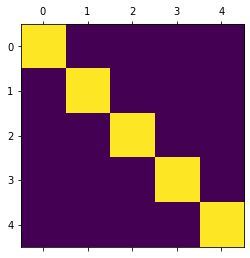

In [53]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [54]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

img_path = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Images/conf_matrix_Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


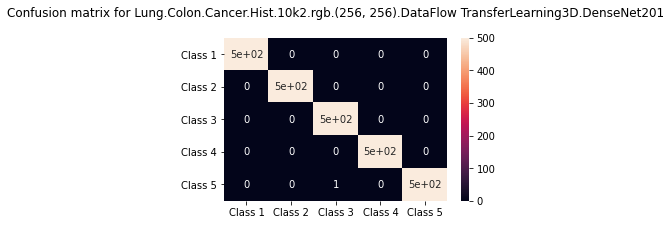

In [55]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (5,3))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True)

img_path = work_dir+'Images/conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [56]:
#Confution Matrix and Classification Report
'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(sklearn.metrics.confusion_matrix(np_test_label, y_pred))
#'''

"\nY_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))\ny_pred = np.argmax(Y_pred, axis=1)\nprint('Confusion Matrix')\nprint(sklearn.metrics.confusion_matrix(np_test_label, y_pred))\n#"

In [57]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
'''
print('Classification Report:')
print(sklearn.metrics.classification_report(test_generator.classes, y_pred))
#'''

"\nprint('Classification Report:')\nprint(sklearn.metrics.classification_report(test_generator.classes, y_pred))\n#"

In [58]:
test_generator.class_indices.keys()

dict_keys(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'])

In [59]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(np_y_true_rearranged, np_y_pred_rearranged, target_names=test_generator.class_indices.keys()))
#'''

Classification Report
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       500
     colon_n       1.00      1.00      1.00       500
    lung_aca       1.00      1.00      1.00       500
      lung_n       1.00      1.00      1.00       500
    lung_scc       1.00      1.00      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [60]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [61]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,auc,false_negatives,false_positives,loss,true_negatives,true_positives,val_accuracy,val_auc,val_false_negatives,val_false_positives,val_loss,val_true_negatives,val_true_positives
0,0,0.877024,0.982051,2968.0,2347.0,4.639043,87589.0,19516.0,0.987179,0.999654,32.0,32.0,4.108712,9952.0,2464.0
1,1,0.973981,0.997854,598.0,568.0,3.976511,89368.0,21886.0,0.999599,1.000000,1.0,1.0,3.730840,9983.0,2495.0
2,2,0.987280,0.999277,293.0,279.0,3.624923,89657.0,22191.0,0.999199,1.000000,2.0,2.0,3.456105,9982.0,2494.0
3,3,0.993907,0.999627,137.0,134.0,3.358318,89802.0,22347.0,0.999199,0.999999,2.0,2.0,3.230162,9982.0,2494.0
4,4,0.993729,0.999480,142.0,139.0,3.145085,89797.0,22342.0,0.999599,1.000000,1.0,1.0,3.029442,9983.0,2495.0


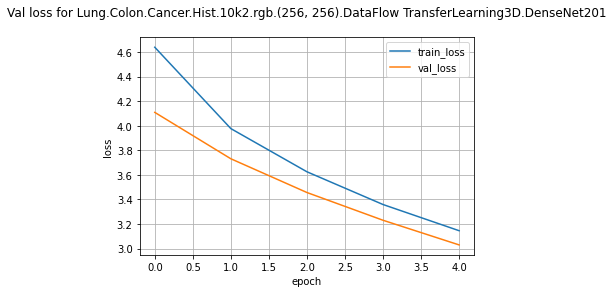

img_path = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Images/vLoss_Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


In [62]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

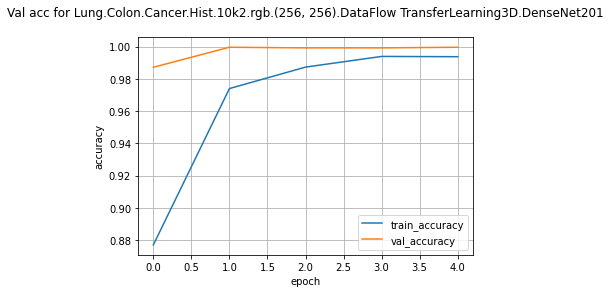

img_path = drive/My Drive/Cancer/Lung and Colon Cancer Histopathological Images/Records/Images/vAcc_Lung.Colon.Cancer.Hist.10k2.rgb.(256, 256).DataFlow.pad0.TransferLearning3D.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.png


In [63]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)